In [1]:
import datetime
import gc
import json
import os
import matplotlib.dates as md
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_info_columns', 500)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.width', 1000)

def safe_map(x):
    """Map known addresses to owners"""
    try: return known_addresses[x]
    except: return x

# known addresses
# Mix of whaleAPI labels and manual labels
with open("data/known_addresses.json", 'r') as f:
    known_addresses = json.load(f)
    
### Read & Clean ETH blockchain data
# From https://etherscan.io/address/0x5754284f345afc66a98fbb0a0afe71e0f007b949#tokentxns
eth = pd.read_csv("data/ethchain.csv", index_col=False)
eth['date'] = pd.to_datetime(eth.DateTime)
eth = eth.drop(columns=['DateTime', 'Txhash', 'UnixTimestamp', 'ContractAddress', 'TokenName'])
eth.columns = ['from', 'to', 'value', 'token', 'date']
eth['chain'] = 'eth'
eth = eth[['date', 'value', 'token', 'from', 'to', 'chain']]
eth.to = eth.to.apply(safe_map)
eth['from'] = eth['from'].apply(safe_map)

### Read & Clean Tron blockchain data
# From https://tronscan.org/#/address/TKHuVq1oKVruCGLvqVexFs6dawKv6fQgFs/transfers
tron = pd.read_csv("data/tronchain.csv")
tron = tron.drop(columns=['transaction_id', 'block', 'contractRet', 'confirmed'])
tron.columns = ['date', 'from', 'to', 'value']
tron['chain'] = 'tron'
tron['token'] = 'USDT'
tron = tron[['date', 'value', 'token', 'from', 'to', 'chain']]
tron['date'] = pd.to_datetime(tron.date)
tron.to = tron.to.apply(safe_map)
tron['from'] = tron['from'].apply(safe_map)

### Read tron minting addr data
# https://tronscan.org/#/address/THPvaUhoh2Qn2y9THCZML3H815hhFhn5YC
mint = pd.read_csv("data/tron_cold.csv")
mint = mint.drop(columns=['transaction_id', 'block', 'contractRet', 'confirmed'])
mint.columns = ['date', 'from', 'to', 'value']
mint['chain'] = 'tron'
mint['token'] = 'USDT'
mint = mint[['date', 'value', 'token', 'from', 'to', 'chain']]
mint['date'] = pd.to_datetime(mint.date)
mint.to = mint.to.apply(safe_map)
mint['from'] = mint['from'].apply(safe_map)

### Unify dataset
df = (
    pd.concat([eth, tron, mint])
      .sort_values(by='date')
      .reset_index(drop=True)
)
# Fix numeric values
df.value = pd.to_numeric(
    df.value.astype(str)
      .str.replace(",", "")
)
# Money coming back to treasury is a negative tx
df.loc[
    (df.to.str.contains('tether'))
    & ~(df['from'].str.contains('mint'))
    & ~(df['from'].str.contains('cold'))
    , 'value'] *= -1
df.sample(4)

,date,value,token,from,to,chain
5767,2021-04-23 16:10:21,-80000000.0,USDT,0x4862733b5fddfd35f35ea8ccf08f5045e57388b3,tether scrambler eth,eth
370,2019-06-20 15:06:50,2597400.0,USDT,tether scrambler eth,0xe0507a0e9fa4885a9c470567a342281627cdc7be,eth
2689,2020-05-15 16:43:00,100000.0,USDT,tether scrambler tron,huobi,tron
446,2019-07-05 18:04:04,195804.0,USDT,tether scrambler eth,0xb4e5b9e0799d83850b16fb25bf75481748f3bf99,eth


In [2]:
### Kraken BTC data from http://api.bitcoincharts.com/v1/csv/
btc = pd.read_csv("data/krakenUSD.csv")
btc.columns = ['unixtime','priceUSD','volumeUSD']
btc['date'] = pd.to_datetime(btc.unixtime, unit='s')
btc.drop(columns='unixtime', inplace=True)
# Resample at hourly frequency
btc = (
    btc.groupby(pd.Grouper(key='date', freq='H'))
       .agg({
           'priceUSD': 'mean',
           'volumeUSD': 'sum'
       })
       .reset_index()
)
btc.volumeUSD = btc.priceUSD * btc.volumeUSD
# Homogeneize date column
btc.date = pd.to_datetime(btc.date.astype(str))

### Binance USDT data from wherever
bn = pd.read_csv("data/binanceUSDT.csv")
bn = bn[['open', 'Volume USDT', 'date']]
bn.columns = ['priceUSDT', 'volumeUSDT', 'date']
# Fix nonsense mixed datetime strings
# 1. Homogeneize to 24hr time
bn.loc[bn.date.str.contains('M'), 'date'] = (
    pd.to_datetime(bn.date.loc[bn.date.str.contains('M')], 
                   format='%Y-%m-%d %I-%p')
      .astype(str)
      .values
)
# now cast it to dt
bn.date = pd.to_datetime(bn.date.astype(str))

### Merge and finalize
btc = pd.merge(btc, bn, on='date', how='inner')
gc.collect()
btc.index = btc.date
btc.sample(3)

,date,priceUSD,volumeUSD,priceUSDT,volumeUSDT
date,,,,,
2020-08-22 00:00:00,2020-08-22 00:00:00,11454.632742,7.051821e+06,11531.34,5.419670e+07
2020-08-16 00:00:00,2020-08-16 00:00:00,11832.786842,1.176443e+06,11852.40,1.864992e+07
2020-10-15 10:00:00,2020-10-15 10:00:00,11325.266316,7.105939e+05,11313.38,2.278906e+07


In [3]:
# Daily BTC Prices from Yahoo Finance Data
dbtc = pd.read_csv("data/daily_btc.csv")
dbtc.Date = pd.to_datetime(dbtc.Date)
dbtc.columns = [x.lower() for x in dbtc.columns]
dbtc

,date,open,high,low,close,adj close,volume
0,2016-05-15,455.759003,458.691986,455.459015,457.567993,457.567993,2.851400e+07
1,2016-05-16,457.585999,458.200012,452.945007,454.162994,454.162994,5.917150e+07
2,2016-05-17,454.009003,455.071991,453.605011,453.782990,453.782990,6.410030e+07
3,2016-05-18,453.691010,455.997986,453.299011,454.618988,454.618988,8.685010e+07
4,2016-05-19,454.523987,454.632996,438.714996,438.714996,438.714996,9.602740e+07
...,...,...,...,...,...,...,...
1822,2021-05-11,55847.242188,56872.542969,54608.652344,56704.574219,56704.574219,6.130840e+10
1823,2021-05-12,56714.531250,57939.363281,49150.535156,49150.535156,49150.535156,7.521540e+10
1824,2021-05-13,49735.433594,51330.843750,46980.019531,49716.191406,49716.191406,9.672115e+10
1825,2021-05-14,49682.980469,51438.117188,48868.578125,49880.535156,49880.535156,5.573750e+10


In [4]:
# TVL Data from defipulse API
tvl = pd.read_csv('data/tvl.csv')
tvl.date = pd.to_datetime(tvl.date)

# Lending data from defipulse API
lend = pd.read_csv('data/lending.csv')
lend.date = pd.to_datetime(lend.date)
def get_rates(r):
    try:  return pd.Series(list(eval(r).values())).mean()
    except:  return 0
def get_speed(r):
    try:  return eval(r)['USDT']['USD']
    except:  return 0
lend['avg_lend'] = lend.lend_rates.apply(get_rates)
lend['avg_borrow'] = lend.borrow_rates.apply(get_rates)
lend['margin'] = lend.avg_borrow - lend.avg_lend

lend['maker_borrow'] = lend.borrow_rates.apply(lambda r : eval(r).get('maker'))
lend['maker_lend'] = lend.lend_rates.apply(lambda r : eval(r).get('maker'))
lend['compound_borrow'] = lend.borrow_rates.apply(lambda r : eval(r).get('compound'))
lend['compound_lend'] = lend.lend_rates.apply(lambda r : eval(r).get('compound'))

lend['usdt_speed'] = lend.interest_speed.apply(get_speed)


# Data scraped from defipulse.com/usd
defi = pd.read_csv("data/defi.csv")
defi.date = pd.to_datetime(defi.date)
defi.usd *= 1_000_000_000
defi.usdt *= 1_000_000_000
defi['other'] = defi.usd - defi.usdt
defi['tether%'] = defi.usdt / defi.usd
defi.sample(3)

,date,usd,usdt,other,tether%
10,2019-11-01,3.100000e+09,2.000000e+09,1.100000e+09,0.645161
21,2020-10-01,1.510000e+10,1.030000e+10,4.800000e+09,0.682119
13,2020-02-01,3.300000e+09,2.300000e+09,1.000000e+09,0.696970


# Exchange Shares

<AxesSubplot:xlabel='date', ylabel='USDT Issued, $B'>

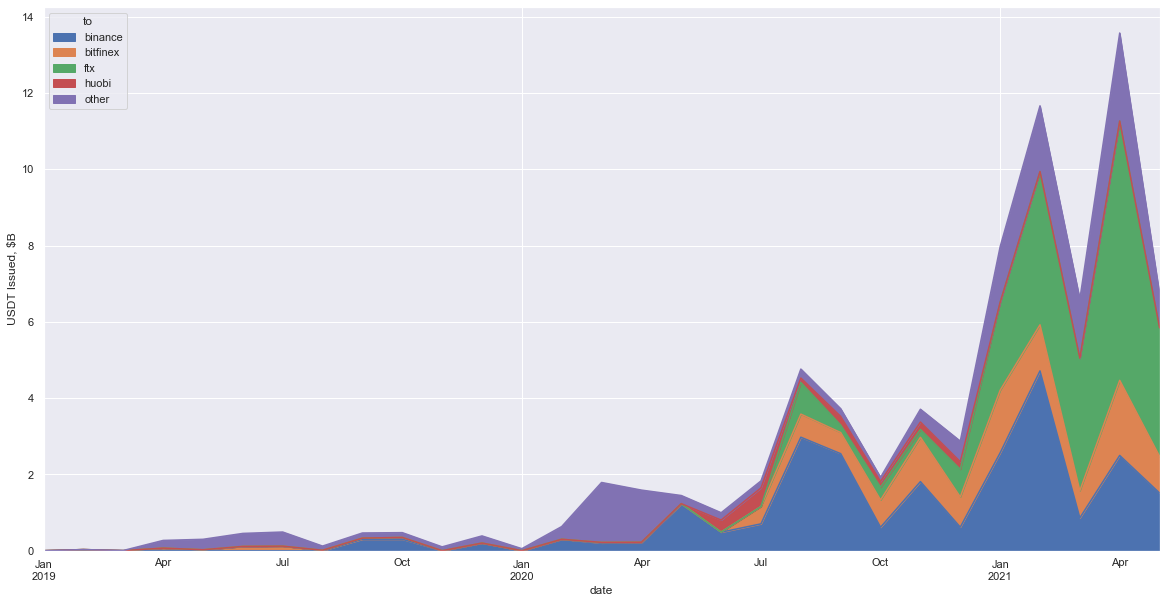

In [5]:
DATE_FROM = '2019-01-01'

dd = df.copy()

dd.loc[
    dd.to.str.len() > 15,
    "to"
] = "other"

dd.loc[dd.to.str.contains('poloniex'), 'to'] = 'other'
dd.loc[dd.to.str.contains('renrenbit'), 'to'] = 'other'
dd.loc[dd.to.str.contains('okex'), 'to'] = 'other'
dd.loc[dd.to.str.contains('nexo'), 'to'] = 'other'
dd.loc[dd.to.str.contains('bitfinex'), 'to'] = 'bitfinex'

dd = dd.loc[
    (dd.date >= DATE_FROM) 
    & (dd.date < (dd.date.max() - datetime.timedelta(days=3)))
]

dd['date'] = dd.date.dt.to_period("M")

ddd = (dd.loc[
        dd['from'].str.contains('scrambler')
    ]
   .groupby(['to', 'date'])
   .value.sum()
   .reset_index()
)

ddd = ddd.loc[~(ddd.to.str.contains('cold'))]
ddd.value /= 1_000_000_000

fig, ax = plt.subplots(figsize = (20, 10))

ax.set_ylabel("USDT Issued, $B")

(ddd.pivot(index='date', columns='to', values='value')
    .fillna(0)
    .plot.area(ax=ax)
)

# Tether Insolvency Number Calculation

Note counting issuances by mint address overcounts a little, since "authorized but not issued" tokens and quarantined are counted in.

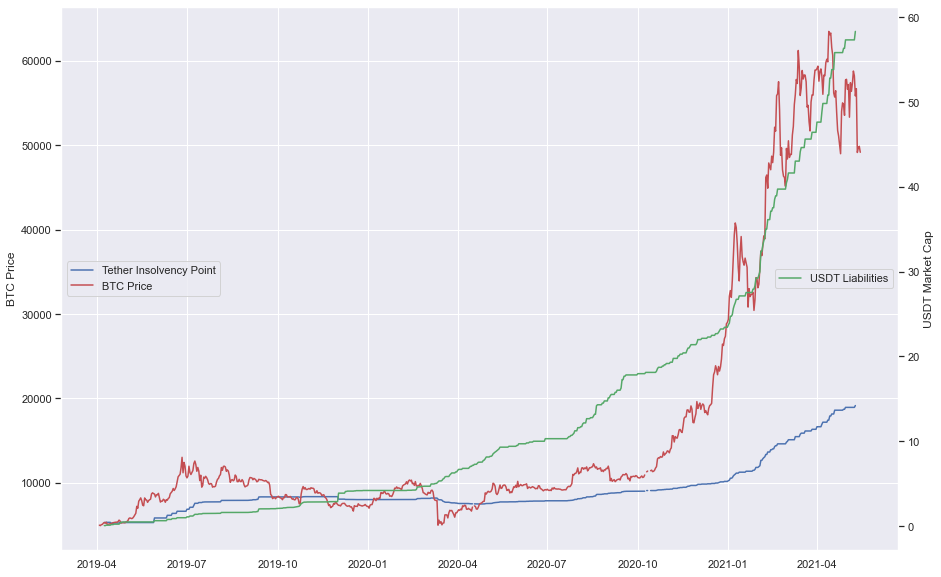

In [6]:
DATE_FROM = '2019-04-03'
DATE_TO = '2021-12-12'

dd = (
    df.loc[(df['from'].str.contains('mint'))
      ].copy()
)
# July 2019 Mint Error removed
dd = dd.loc[~((dd.date <= '2019-08-08') & (dd.value > 1e9))]

dd = (dd
      .set_index('date')
      .resample('D')
      .sum()
      .reset_index()
)

st = pd.merge(
    dbtc.loc[
        (dbtc.date >= DATE_FROM)
         & (dbtc.date <= DATE_TO)
    ],dd, on='date', how='left')
st.fillna(0.)

st['stash'] = (st.value / st.close).cumsum()
st['liabilities'] = st.value.cumsum()
st['breakeven'] = st.liabilities / st.stash

st = st.loc[
    (st.date >= DATE_FROM)
     & (st.date <= DATE_TO)
]

fig, ax = plt.subplots(figsize=(15,10))

lns1 = ax.plot(st.date, st.breakeven)
ax2 = ax.twinx()
lns2 = ax.plot(st.date, st.close, color='r')
lns3 = ax2.plot(st.date, (st.liabilities / 1_000_000_000), color='g')
ax2.grid(False)

ax.legend(['Tether Insolvency Point', 'BTC Price'], loc='center left')
ax2.legend(['USDT Liabilities'], loc='right')

ax.set_ylabel("BTC Price")
ax2.set_ylabel("USDT Market Cap")
# plt.legend(labels=["USDT Market Cap"], loc=0)
plt.show()

# DeFi plot

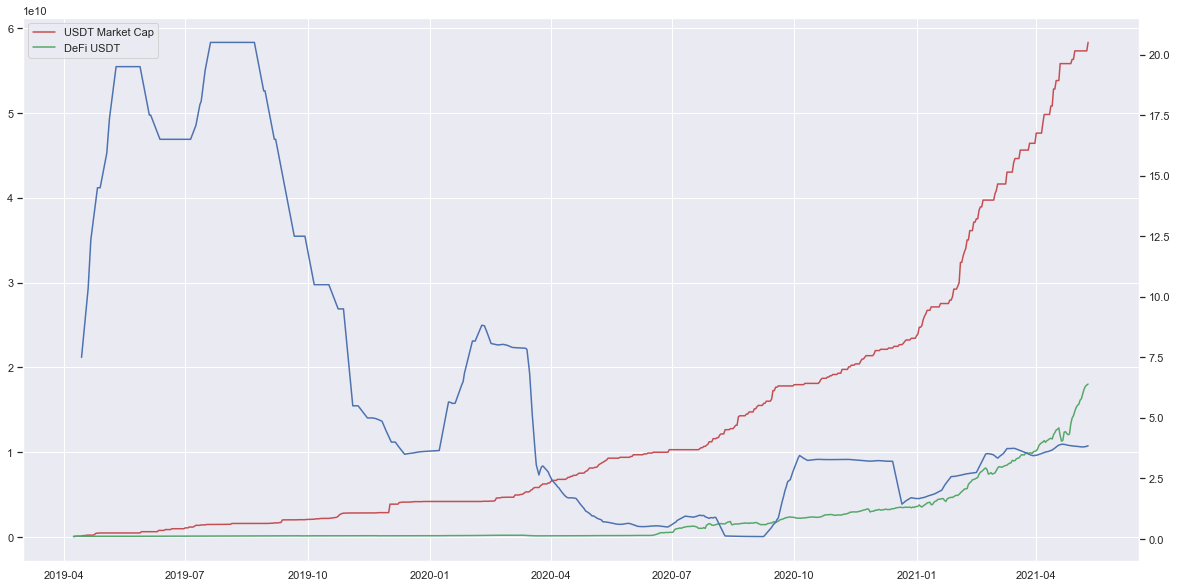

In [24]:
DATE_FROM = '2018-04-03'
DATE_TO = '2021-12-12'

dd = (
    df.loc[(df['from'].str.contains('mint'))
      ].copy()
)
# July 2019 Mint Error removed
dd = dd.loc[~((dd.date <= '2019-08-08') & (dd.value > 1e9))]

dd = (dd
      .set_index('date')
      .resample('D')
      .sum()
      .reset_index()
)
dd.value = dd.value.cumsum()
# dd = dd.loc[dd.date >= '2020-01-01']
dd = pd.merge(dd, lend, on='date')


fig, ax = plt.subplots(figsize=(20,10))

ax.plot(dd.date, dd.value, color='r')
ax.plot(dd.date, dd.total, color='g')
ax2 = ax.twinx()
# Rolling mean of avg borrow rates
ax2.plot(dd.date, dd.maker_borrow.rolling(7).mean())

ax2.grid(False)
ax.legend(['USDT Market Cap', 'DeFi USDT'], loc='upper left')
plt.show()

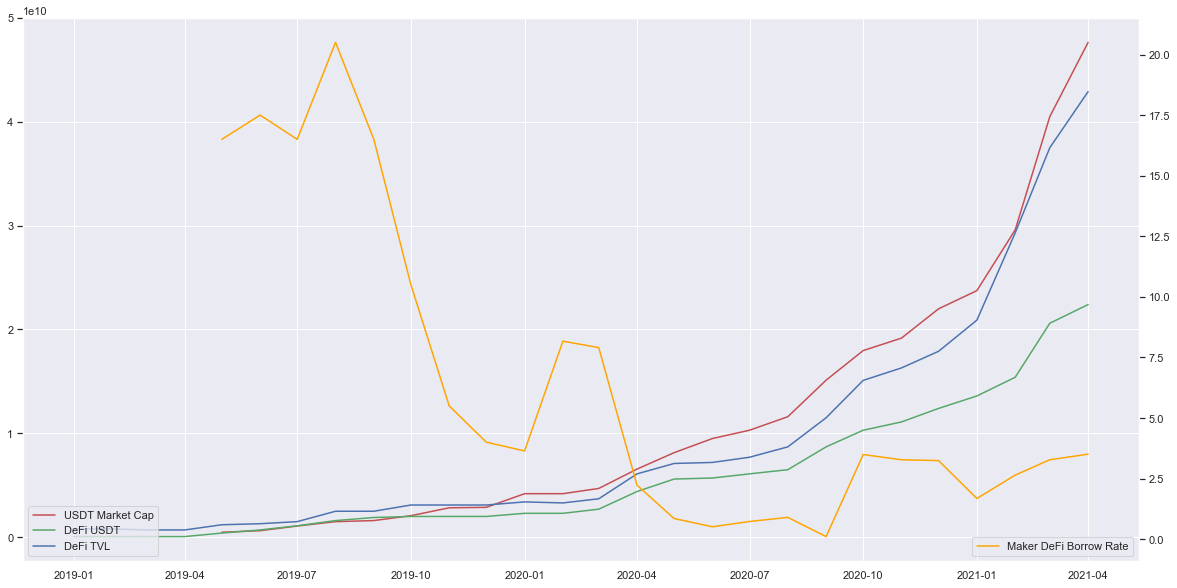

In [30]:
dfi = pd.merge(defi, dd, on='date', how='left')

fig, ax = plt.subplots(figsize=(20,10))

ax.plot(dfi.date, dfi.value, color='r')
ax.plot(dfi.date, dfi.usdt_x, color='g')
ax.plot(dfi.date, dfi.usd, color='b')
ax2 = ax.twinx()
# Rolling mean of avg borrow rates
ax2.plot(dfi.date, dfi.maker_borrow, color='orange')

ax2.grid(False)
ax.legend(['USDT Market Cap', 'DeFi USDT', 'DeFi TVL'], loc='lower left')
ax2.legend(['Maker DeFi Borrow Rate'], loc='lower right')
plt.show()

# The noose is tightening

In [75]:
### Read & Clean Tron blockchain data
# From https://tronscan.org/#/address/TKHuVq1oKVruCGLvqVexFs6dawKv6fQgFs/transfers
tron = pd.read_csv("data/scrambler_new.csv")
tron = tron.drop(columns=['transaction_id', 'block', 'contractRet', 'confirmed'])
tron.columns = ['date', 'from', 'to', 'value']
tron['token'] = 'USDT'
tron = tron[['date', 'value', 'token', 'from', 'to', 'chain']]
tron['date'] = pd.to_datetime(tron.date)
tron.to = tron.to.apply(safe_map)
tron['from'] = tron['from'].apply(safe_map)
tron['direction'] = (tron['from'] == 'tether scrambler tron').map({True: 'out', False: 'in'})
tron

,date,value,token,from,to,chain,direction
0,2021-05-19 02:27:12,20000000.0,USDT,binance,tether scrambler tron,tron,in
1,2021-05-19 02:12:03,10000000.0,USDT,TN5rNoA4ZibQS15LxVptSgwwztXqfB6jgd,tether scrambler tron,tron,in
2,2021-05-19 01:53:57,10000000.0,USDT,TN5rNoA4ZibQS15LxVptSgwwztXqfB6jgd,tether scrambler tron,tron,in
3,2021-05-18 23:25:12,3000000.0,USDT,TD8mvHVhMKX2wCgbPwZehWAk6wEvNtHcgL,tether scrambler tron,tron,in
4,2021-05-18 20:14:45,50000000.0,USDT,tether scrambler tron,binance,tron,out
...,...,...,...,...,...,...,...
1995,2020-05-04 14:11:33,600000.0,USDT,tether scrambler tron,bitfinex,tron,out
1996,2020-05-04 14:07:45,5001000.0,USDT,tether scrambler tron,binance,tron,out
1997,2020-05-04 12:02:54,5000000.0,USDT,tether scrambler tron,binance,tron,out
1998,2020-05-04 03:25:12,7000000.0,USDT,tether scrambler tron,binance,tron,out


In [121]:
tron['day'] = tron.date.dt.date
tron = tron.loc[~tron['from'].str.contains('cold')]
tt = tron.groupby(['day', 'direction']).sum().reset_index()
tt['date'] = tt.day
tt = tt[['date', 'direction', 'value']]
tt

,date,direction,value
0,2020-05-02,out,1.000000e+07
1,2020-05-04,out,4.362100e+07
2,2020-05-05,out,5.740300e+07
3,2020-05-06,out,6.001500e+07
4,2020-05-07,out,7.755300e+07
5,2020-05-08,out,1.293040e+08
6,2020-05-09,out,9.620000e+07
7,2020-05-10,out,3.690000e+07
8,2020-05-11,out,8.445000e+07
9,2020-05-12,out,1.104000e+08


In [128]:
# Remove chain swap
tt = tt.loc[tt.date.astype(str) != '2021-02-03']

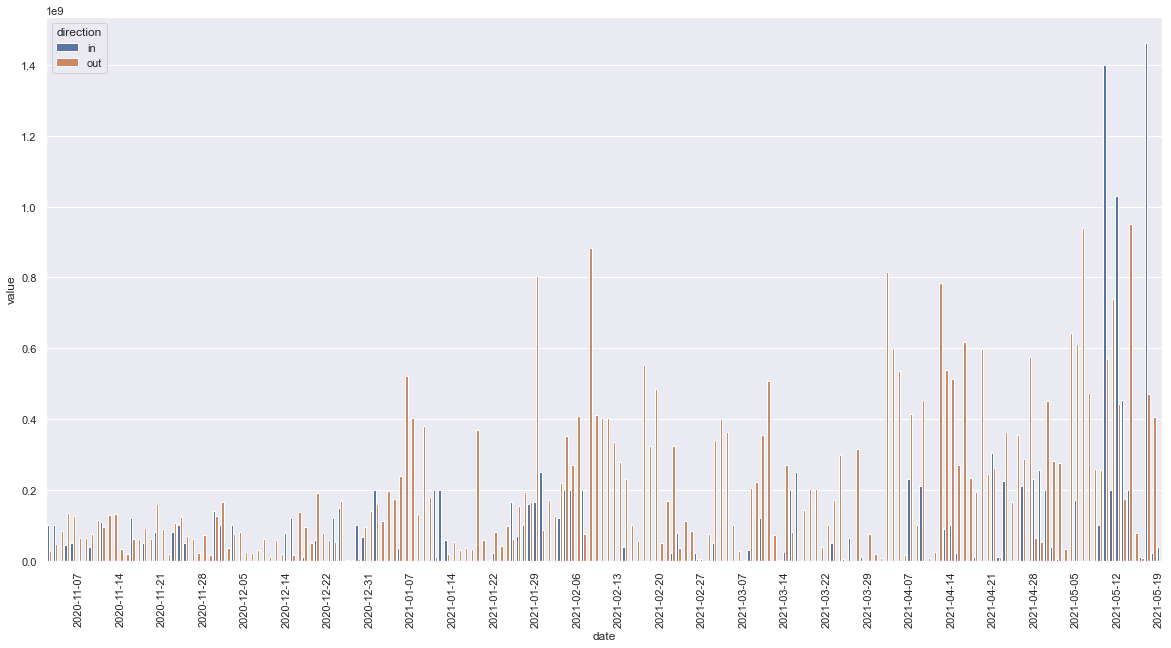

In [129]:
fig, ax = plt.subplots(figsize=(20,10))


sns.barplot(
    data=tt.loc[tt.date.astype(str) > '2020-11-01'],
    x="date", y='value', 
    hue="direction",
    ax=ax
)
ax.xaxis.set_major_locator(md.WeekdayLocator(byweekday=1, interval=1))
plt.setp(ax.xaxis.get_majorticklabels(), rotation = 90)
plt.show()

# VAR

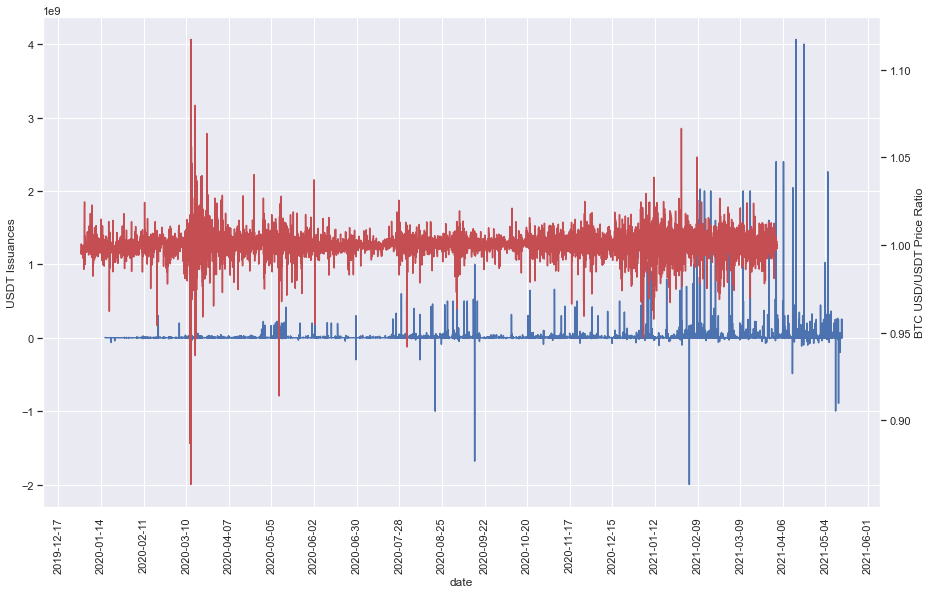

In [9]:
dd = (df.loc[
    ~(df['from'].str.contains('mint'))
     & (df.date >= '2020-01-15')
    ]
    .sort_values(by='date')
    .copy()
)
dd = (
    dd.groupby(pd.Grouper(key='date', freq='H'))
      .agg({'value': 'sum'})
)

fig, ax = plt.subplots(figsize=(15,10))

sns.lineplot(data=dd, x='date', y='value', ax=ax)
ax2 = ax.twinx()
(btc.priceUSD / btc.priceUSDT).plot(ax=ax2, color='r')
ax2.grid(False)
ax2.set_ylabel("BTC USD/USDT Price Ratio")
ax.set_ylabel("USDT Issuances")
ax.xaxis.set_major_locator(md.WeekdayLocator(byweekday=1, interval=4))
ax.xaxis.set_major_formatter(md.DateFormatter('%Y-%m-%d'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation = 90)
plt.show()

In [10]:
dd = (df.loc[
    (df['from'].str.contains('mint'))
     & (df.date >= '2020-01-15')]
    .groupby(pd.Grouper(key='date', freq='H'))
    .agg({'value': 'sum'})
    .reset_index()
)
dd = pd.merge(dd, btc, on='date')
dd

ValueError: 'date' is both an index level and a column label, which is ambiguous.

In [ ]:
import statsmodels
import statsmodels.api as sm
statsmodels.tsa.vector_ar.var_model.VAR(
    endog=dd.priceUSD, 
    exog=dd.value
).fit(maxlags=10).summary()